In [61]:
import numpy as np # for linear algebra
import pandas as pd # for data processing
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt


from subprocess import check_output
print(check_output(["ls","../../Downloads/Dataset/Google_negative_reviews"]).decode("utf8"))

stop_words = set(stopwords.words('english'))

GoogleNews-vectors-negative300.bin.gz
GoogleNews-vectors-negative300.bin.gz.zip
cnn_submission.csv
jigsaw-toxic-comment-classification-challenge
test_clean_data.csv
train_clean_data.csv



In [35]:
EMBEDDING_DIM = 300 # how big is each word vector
MAX_VOCAB_SIZE = 175303 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 200 # max number of words in a comment to use

#training params
batch_size = 256 
num_epochs = 2 

In [7]:
train_comments = pd.read_csv("../../Downloads/Dataset/Google_negative_reviews/jigsaw-toxic-comment-classification-challenge/train.csv",sep=',',header = 0)

In [9]:
train_comments.columns = ['id','comment_text','toxic','severe_toxic','obscene','threat','insult','identity_hate']
print("num train ",train_comments.shape[0])
train_comments.head()

num train  159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
LABEL_NAMES = ['toxic','severe_toxic','obscene','threat','insult'
              ,'identity_hate']
y_train = train_comments[LABEL_NAMES].values

In [13]:
test_comments = pd.read_csv("../../Downloads/Dataset/Google_negative_reviews/jigsaw-toxic-comment-classification-challenge/test.csv",sep=',',header = 0)


In [14]:
test_comments.columns = ['id','comment_text']
print("num test: ",test_comments.shape[0])
test_comments.head()

num test:  153164


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [17]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [18]:
train_comments.fillna('_NA_')
train_comments = standardize_text(train_comments, "comment_text")
train_comments.to_csv("train_clean_data.csv")
train_comments.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhytheeditsmadeundermyusernamehar...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww!hematchesthisbackgroundcolouri'mseemingl...,0,0,0,0,0,0
2,000113f07ec002fd,"heyman,i'mreallynottryingtoeditwarit'sjustthat...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nmore\nican'tmakeanyrealsuggestionsonimprove...",0,0,0,0,0,0
4,0001d958c54c6e35,"you,sir,aremyheroanychanceyourememberwhatpaget...",0,0,0,0,0,0


In [19]:
test_comments.fillna('_NA_')
test_comments = standardize_text(test_comments, "comment_text") 
test_comments.to_csv("test_clean_data.csv")
test_comments.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...
1,0000247867823ef7,from rfc \n\n the title is fine as it is...
2,00013b17ad220c46,""" \n\n sources \n\n zawe ashton on lap..."
3,00017563c3f7919a,"if you have a look back at the source, the in..."
4,00017695ad8997eb,i don't anonymously edit articles at all


In [26]:
tokenizer = RegexpTokenizer(r'\w+')
clean_train_comments = pd.read_csv("../../Downloads/Dataset/Google_negative_reviews/train_clean_data.csv")
clean_train_comments['comment_text'] = clean_train_comments['comment_text'].astype('str')
clean_train_comments.dtypes
clean_train_comments["tokens"] = clean_train_comments["comment_text"].apply(tokenizer.tokenize)
# delete Stop Words
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
   
clean_train_comments.head()


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,..."
1,1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,"[aww, matches, background, colour, seemingly, ..."
2,2,000113f07ec002fd,"hey man, i'm really not trying to edit war it...",0,0,0,0,0,0,"[hey, man, really, trying, edit, war, guy, con..."
3,3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,"[make, real, suggestions, improvement, wondere..."
4,4,0001d958c54c6e35,"you, sir, are my hero any chance you remember...",0,0,0,0,0,0,"[sir, hero, chance, remember, page]"


In [27]:
clean_test_comments = pd.read_csv("../../Downloads/Dataset/Google_negative_reviews/test_clean_data.csv")
clean_test_comments['comment_text'] = clean_test_comments['comment_text'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["comment_text"].apply(tokenizer.tokenize)
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])

clean_test_comments.head()





,Unnamed: 0,id,comment_text,tokens
0,0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...,"[yo, bitch, ja, rule, succesful, ever, whats, ..."
1,1,0000247867823ef7,from rfc \n\n the title is fine as it is...,"[rfc, title, fine, imo]"
2,2,00013b17ad220c46,""" \n\n sources \n\n zawe ashton on lap...","[sources, zawe, ashton, lapland]"
3,3,00017563c3f7919a,"if you have a look back at the source, the in...","[look, back, source, information, updated, cor..."
4,4,00017695ad8997eb,i don't anonymously edit articles at all,"[anonymously, edit, articles]"


In [28]:
all_training_words = [word for tokens in clean_train_comments["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in clean_train_comments["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

5638093 words total, with a vocabulary size of 175303
Max sentence length is 1250


In [29]:
all_test_words = [word for tokens in clean_test_comments["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in clean_test_comments["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

4969758 words total, with a vocabulary size of 203321
Max sentence length is 1667


In [30]:
word2vec_path = "../../Downloads/Dataset/Google_negative_reviews/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path,binary = True)

In [31]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged



In [32]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)


In [33]:
training_embeddings = get_word2vec_embeddings(word2vec, clean_train_comments, generate_missing=True)
# test_embeddings = get_word2vec_embeddings(word2vec, clean_test_comments, generate_missing=True)

In [37]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_train_comments["comment_text"].tolist())
training_sequences = tokenizer.texts_to_sequences(clean_train_comments["comment_text"])


In [38]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 190289 unique tokens.


In [39]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(190290, 300)


In [40]:
# similar to test the sequence
test_sequences = tokenizer.texts_to_sequences(clean_test_comments["comment_text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [62]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs,axis=1)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [63]:
x_train = train_cnn_data
y_tr = y_train

In [64]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)), False)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     57087000    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 198, 128)     115328      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 197, 128)     153728      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_12 

In [67]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, 
                               patience=4, verbose=1)

callbacks_list = [early_stopping]


In [68]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, 
                 callbacks=callbacks_list, validation_split=0.1, 
                 shuffle=True, 
                 batch_size=batch_size)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 572s 4ms/step - loss: 0.0977 - acc: 0.9685 - val_loss: 0.0685 - val_acc: 0.9764
Epoch 2/2
143613/143613 [==============================] - 594s 4ms/step - loss: 0.0700 - acc: 0.9756 - val_loss: 0.0623 - val_acc: 0.9779


In [69]:
y_test = model.predict(test_cnn_data, batch_size=1024, verbose=1)

153164/153164 [==============================] - 311s 2ms/step


In [70]:
#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_comments['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_submission.csv", index=False)

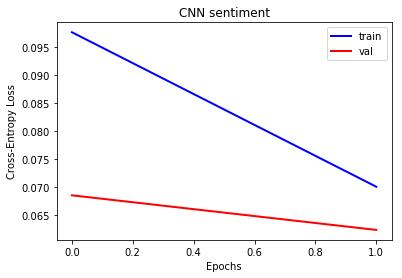

In [71]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

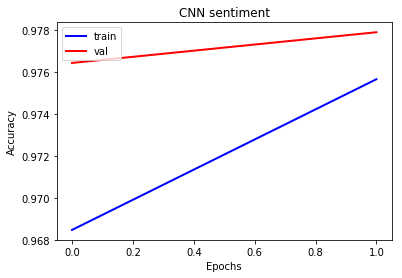

In [72]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
